In [1]:
import tensorflow as tf

In [2]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import shutil

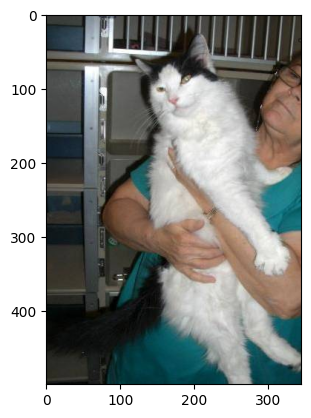

In [3]:
# look at an image for fun
plt.imshow(image.load_img('./dogs-vs-cats/train/cat.25.jpg'))
plt.show()

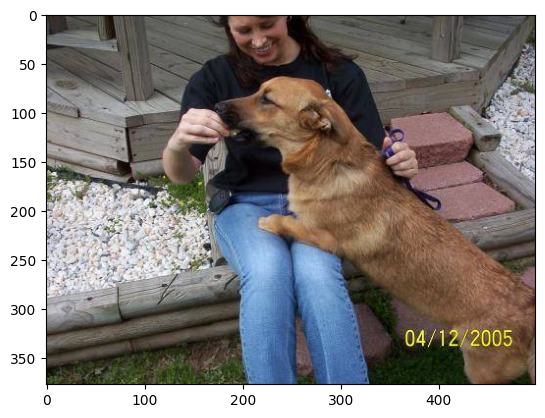

In [4]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('./dogs-vs-cats/train/dog.52.jpg'))
plt.show()

In [5]:
if os.path.exists('./data'):
  shutil.rmtree('./data')

In [6]:
paths = ['./data', './data/train', './data/train/dogs', './data/train/cats', './data/test', './data/test/dogs', './data/test/cats']

for path in paths:
  if not os.path.exists(path):
    os.mkdir(path)


In [7]:
for (dirpath, dirnames, filenames) in os.walk('./dogs-vs-cats'):
  dirpath = dirpath.replace("\\","/")
  cat_array = [x for x in filenames if 'cat' in x]
  dog_array = [x for x in filenames if 'dog' in x]

  if (len(cat_array) == len(dog_array) and len(cat_array) > 0 and len(dog_array) > 0):
    for i in range(len(cat_array)):
      if i < 10000:
        shutil.copyfile(f"{dirpath}/{cat_array[i]}", f"./data/train/cats/{cat_array[i]}")
        shutil.copyfile(f"{dirpath}/{dog_array[i]}", f"./data/train/dogs/{dog_array[i]}")
      else:
        shutil.copyfile(f"{dirpath}/{cat_array[i]}", f"./data/test/cats/{cat_array[i]}")
        shutil.copyfile(f"{dirpath}/{dog_array[i]}", f"./data/test/dogs/{dog_array[i]}")


In [8]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [9]:
train_path = './data/train'
test_path = './data/test'

In [10]:
# useful for getting number of files
train_image_files = glob(train_path + '/*/*.jpg')
test_image_files = glob(test_path + '/*/*.jpg')

In [11]:
folders = glob(train_path + '/*')
folders

['./data/train\\cats', './data/train\\dogs']

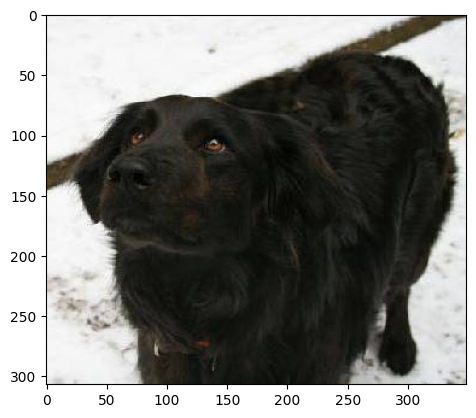

In [12]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(train_image_files)))
plt.show()

In [13]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

In [14]:
# map the data into feature vectors
x = Flatten()(ptm.output)

In [15]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [16]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [17]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
batch_size = 32

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

test_generator = gen.flow_from_directory(
  test_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [19]:
Ntrain = len(train_image_files)
Ntest = len(test_image_files)

# Figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_test = np.zeros((Ntest, D))
Y_test = np.zeros(Ntest)

1/1 [==============================] - 2s 2s/step


In [20]:
# populate X_train and Y_train
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y
  
  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

1/1 [==============================] - 1s 876ms/step
32
1/1 [==============================] - 0s 21ms/step
64
1/1 [==============================] - 0s 20ms/step
96
1/1 [==============================] - 0s 19ms/step
128
1/1 [==============================] - 0s 20ms/step
160
1/1 [==============================] - 0s 20ms/step
192
1/1 [==============================] - 0s 20ms/step
224
1/1 [==============================] - 0s 20ms/step
256
1/1 [==============================] - 0s 19ms/step
288
1/1 [==============================] - 0s 20ms/step
320
1/1 [==============================] - 0s 20ms/step
352
1/1 [==============================] - 0s 19ms/step
384
1/1 [==============================] - 0s 20ms/step
416
1/1 [==============================] - 0s 19ms/step
448
1/1 [==============================] - 0s 20ms/step
480
1/1 [==============================] - 0s 26ms/step
512
1/1 [==============================] - 0s 20ms/step
544
1/1 [==============================] - 0s 20ms/ste

In [21]:
# populate X_valid and Y_valid
i = 0
for x, y in test_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_test[i:i + sz] = features
  Y_test[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Ntest:
    print('breaking now')
    break
print(i)

1/1 [==============================] - 1s 507ms/step
breaking now
5000


In [22]:
X_train.max(), X_train.min()

(900.3675537109375, 0.0)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_test2 = scaler.transform(X_test)

In [24]:

from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_test2, Y_test))

c:\Users\danbl\miniconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.0
0.9822


In [25]:
# Do logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

In [26]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [28]:
# Can try both normalized and unnormalized data
r = linearmodel.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, Y_test),
)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.8736 - accuracy: 0.9647 - val_loss: 0.7693 - val_accuracy: 0.9740
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3915 - accuracy: 0.9851 - val_loss: 0.9669 - val_accuracy: 0.9768
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2055 - accuracy: 0.9912 - val_loss: 1.1209 - val_accuracy: 0.9786
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1534 - accuracy: 0.9936 - val_loss: 1.1370 - val_accuracy: 0.9810
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1797 - accuracy: 0.9940 - val_loss: 1.7134 - val_accuracy: 0.9748
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1044 - accuracy: 0.9959 - val_loss: 1.2937 - val_accuracy: 0.9826
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0919 - accuracy: 0.9967 - val_loss: 1.4537 - val_accuracy: 0.9812
Epoch 

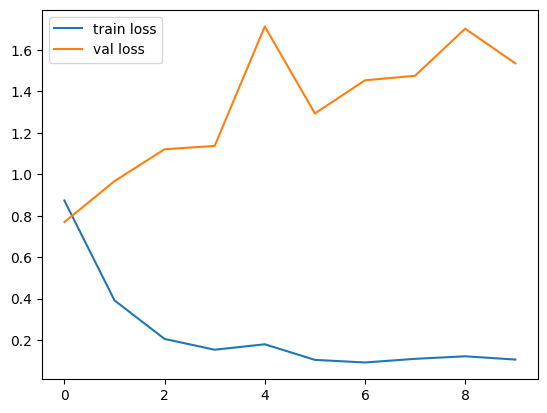

In [29]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

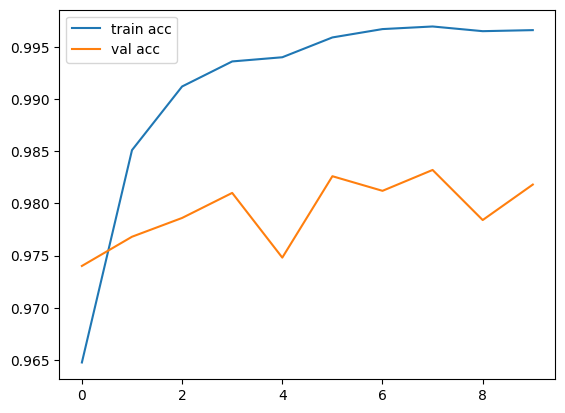

In [30]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()